# Restaurant Bill Reader

## Objective
Extract total bill amount and date from the restaurant bill receipts. 

## Approach
  
1.   Image pre-processing  
     i.     Bill detection and cropping  
     ii.    Image denoising  
     iii.   Image rotation correction
2.   OCR
3.   Data Annotation  
4.   Named Entity Recognition (NER)


In [232]:
# import required libraries
import os
import glob
import random
import datetime
import numpy as np

import cv2
import spacy
from lxml import etree
from google.colab.patches import cv2_imshow

try:
    import pytesseract
except ImportError:
    # install Tesseract OCR if not already installed
    !apt update
    !apt install tesseract-ocr
    !apt install libtesseract-dev
    !pip install pytesseract
    import pytesseract

## Data-set
For this assignment, ten random restaurant bills are downloaded from Google Search.

In [233]:
image_file_paths = glob.glob('data/images/*.png')
image_file_paths

['images/Img5.png',
 'images/Img4.png',
 'images/Img6.png',
 'images/Img9.png',
 'images/Img3.png',
 'images/Img8.png',
 'images/Img2.png',
 'images/Img1.png',
 'images/Img10.png',
 'images/Img7.png']

### Load images

In [234]:
images = []

for img_path in image_file_paths:
    # use opencv to read the images
    image = cv2.imread(img_path)
    images.append(image)

## Image pre-processing 

### Bill detection and cropping
For bill detection from the image, morphological operations and blob detection modules from opencv could be used.  
Skipping this part and adding it to future scope section. 

### Image denoising

original image:


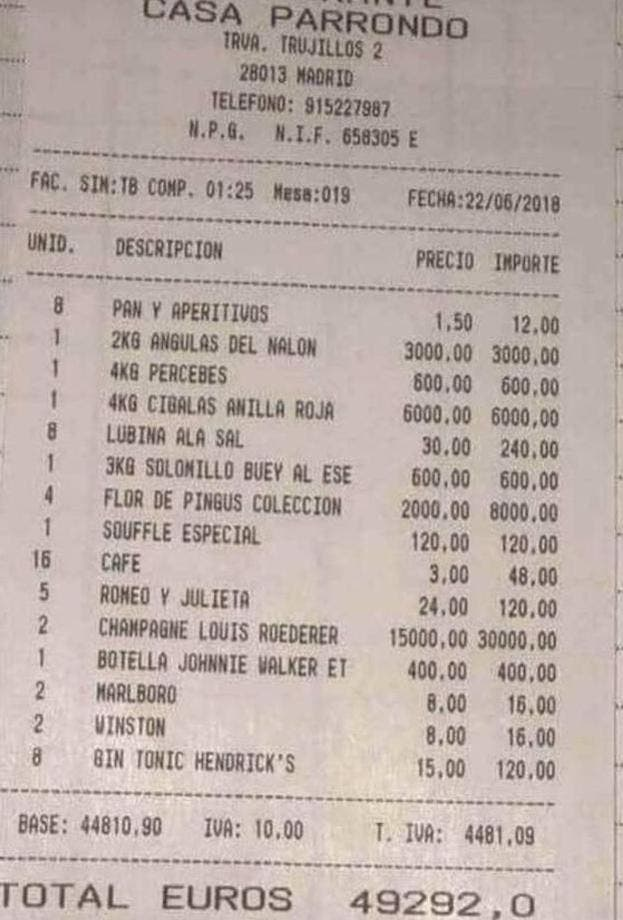

denoised image:


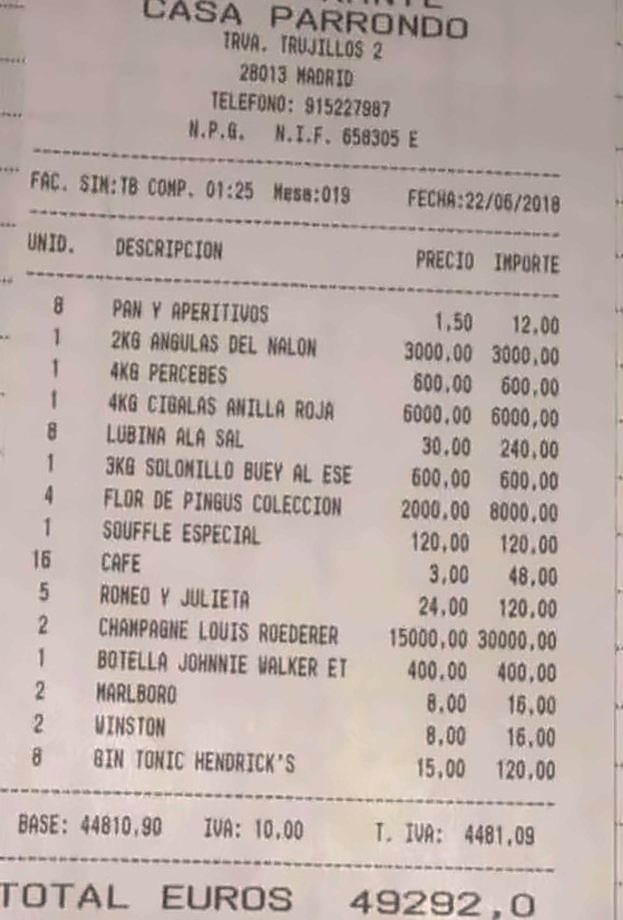

In [235]:
denoised_images = []

for image in images:
    # use opencv denoising module and apply on each image
    denoised_img = cv2.fastNlMeansDenoisingColored(image)
    denoised_images.append(denoised_img)

print("original image:")
cv2_imshow(image)
print("denoised image:")
cv2_imshow(denoised_img)

### Image rotation correction

In [236]:
def correct_rotation(image):
    # convert the image to grayscale and flip the foreground and background 
    # to ensure foreground is now "white" and the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # threshold the image, setting all foreground pixels to 255 
    # and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # grab the (x, y) coordinates of all pixel values that are 
    # greater than zero, then use these coordinates to compute a rotated 
    # bounding box that contains all coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the range [-90, 0); 
    # as the rectangle rotates clockwise the returned angle trends to 0 
    # -- in this special case we need to add 90 degrees to the angle
    if angle < -45:
      angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make it positive
    else:
      angle = -angle
    
    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, 
                             borderMode=cv2.BORDER_REPLICATE)
    return rotated

original image:


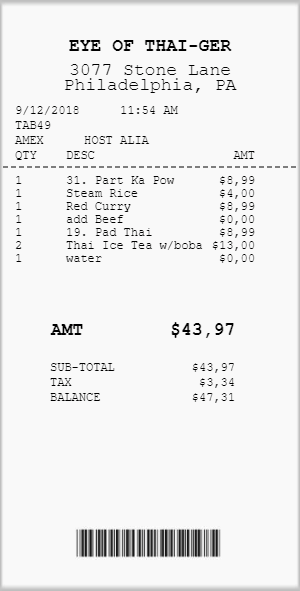

rotated image:


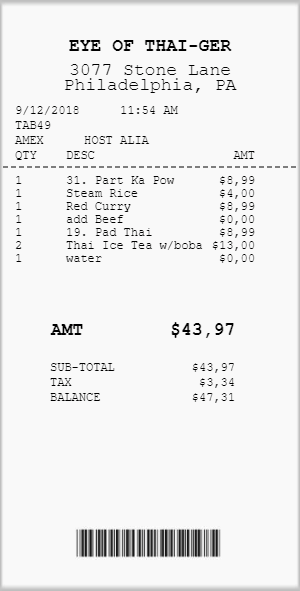

In [237]:
rotated_images = []

for i, image in enumerate(denoised_images):
    rotated = correct_rotation(image)
    rotated_images.append(rotated)
    if i == 0:
        # compare first original and rotated image
        print("original image:")
        cv2_imshow(image)
        print("rotated image:")
        cv2_imshow(rotated)

## OCR

To perform OCR on the pre-processed image following are the ways:  


1.   `Tesseract OCR` on complete bill image - in case of 300+ dpi images
2.   **Text segmentation** (line-by-line) followed by `Tesseract OCR` on each segmented text (line/sentense) box image

Here, Tesseract OCR is directly applied on the whole image using `pytesseract` lib



In [238]:
texts = []

# to set relevant segmentation mode for pytesseract to recognize more text
custom_oem_psm_config = r'--oem 3 --psm 6'

for i, image in enumerate(rotated_images):
    # pytesseract assumes the image to be in RGB color space
    # opencv reads the images in BGR color space 
    # conver the image from BGR to RGB before passing to pytesseract
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    text = pytesseract.image_to_string(img_rgb, config=custom_oem_psm_config)
    texts.append(text)
    # print one sample result
    if i == 1: print(text)

THQ
J Biman,
atieee fan
BARAT
AASWAD
(Sarjoshi Hospitality Pvt Ltd)
T2 Airport Andheri (E),Mumbai 4000099
sessn-==---= TAX INVOICE ---=-=----=--
Date: 01/07/17 Bill No. : 34
PBoy: COUNTER
Particulars Qty Rate Amount
COFFEE 1 90 90
‘Sub Total : 90.00
‘$ GST @9% : 8.10
Cost 6%: © 8.10
nn Total : 106
ance cenernaracenanenosssossanananacasn
GST NO. 27AAUCSB423L1Z1 (04:31 AM)
SAC ‘NO. 004410
a


The results of Tesseract OCR are saved in text files for each image.  
This data will be the data for annotation to train NER model.

In [239]:
# # write the text extracted from images using OCR to text file 
# # for annotation purpose

# for i, text in enumerate(texts):
#     with open("data/texts/{}.txt".format(os.path.basename(image_file_paths[i])), 
#               'w') as f:
#         f.write(text)

## Data Annotation
Data annotation is done using ***General Architecture for Text Engineering*** -- [GATE](https://gate.ac.uk/) tool.

Steps to annotate the text data:  


1.   Right click on **Language Resources** --> **New** --> **GATE Document**  
2.   In **sourceUrl**, select the text file to be annotated



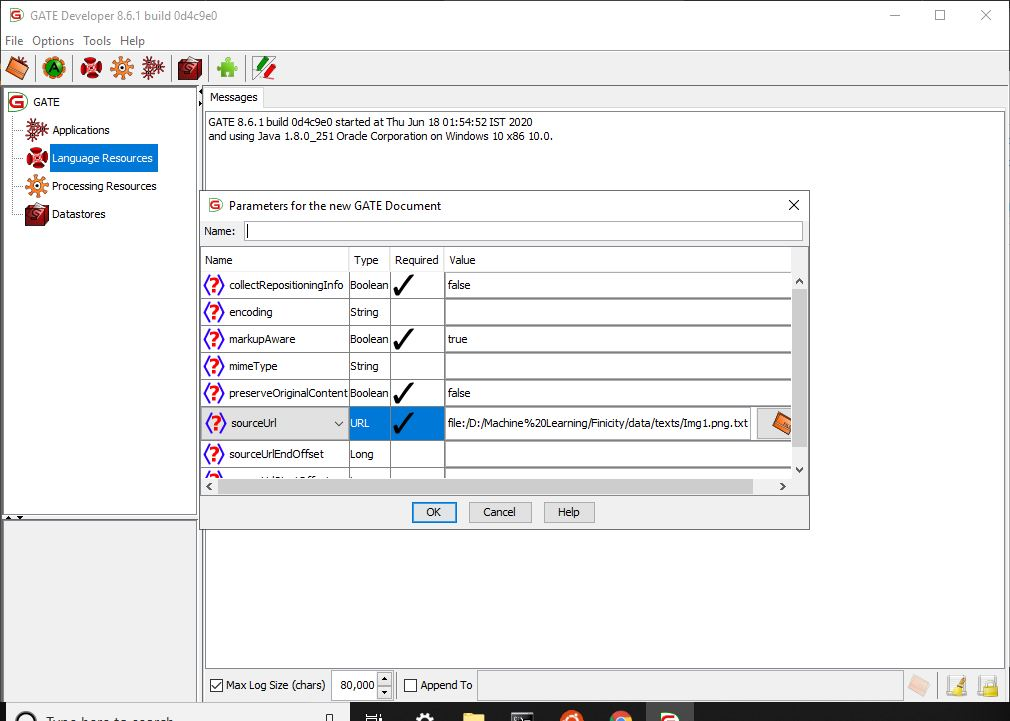

In [240]:
read_text_to_annotate = cv2.imread("GATE-annotation-load.JPG")
cv2_imshow(read_text_to_annotate)

3.   Click on **Annotation Sets**
4.   Select the text to be annotated
5.   Right click, enter the label name and press Enter

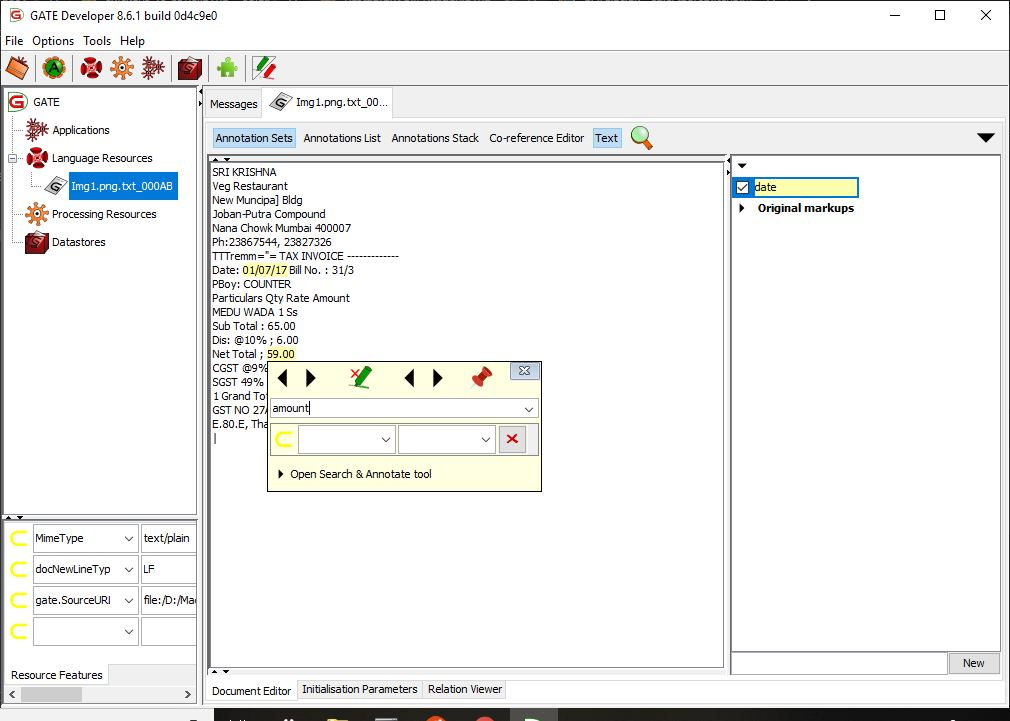

In [241]:
annotate_text = cv2.imread("GATE-annotation-ann.JPG")
cv2_imshow(annotate_text)

## Training spaCy NER model

In [242]:
def gate_xml_parser(gate_xml_path):
    """
    Read the annotated text (GATE XML) 
    and convert to the format required to train spaCy NER model
    """
    with open(gate_xml_path, 'rb') as f:
        gate_xml_text = f.read()

    root = etree.XML(gate_xml_text)

    # contents is the extracted text using OCR
    contents = ''
    # entities are the labels along with the start and end location 
    # of the annotated entity
    entities = {'entities': []}

    for r in root.xpath('''//Node[@id]
                                [following-sibling::node()
                                    [1]
                                    [self::text()]
                                    [normalize-space() != ""]]
                                [following-sibling::node()
                                    [2]
                                    [self::Node[@id]]]'''):
        if len(contents) < int(r.get('id')):
            contents += ' ' * (int(r.get('id')) - len(contents))
        contents += r.tail

    for r in root.xpath("//Annotation"):
        if r.get('Type') != 'paragraph':
            entities["entities"].append([int(r.get('StartNode')),  # start loc
                                         int(r.get('EndNode')),   # end loc
                                         r.get('Type')])  # label
          
    data_point = [contents, entities]
    return data_point


def convert_gate_to_spacy():
    """
    Convert all the annotated data to [contents, entities] format one-by-one 
    """
    data = []

    for gate_xml_path in glob.glob("data/annotations/*.xml"):
        data_point = gate_xml_parser(gate_xml_path)
        data.append(data_point)

    return data

In [243]:
data = convert_gate_to_spacy()
data

[['Ma & Paâ€™s Bake Shop.\nBest Donuts & Cakes in Town!\nâ€˜Server sKEN DOB: 10/9/2018\n06344 PM Torgaeie\n18/1 1710156\nSALE\nVISA 1048614\nCard XXXXXXXKXXXX2227\nCard Presents JOEY SMITH\nCard Entry Method? S\nApproval: 535665\n1 Dozen Donuts $10.99\n1 Box 0 Joe $6.99\nAmounts $17.98\nTax? $1.35\n+ Tips\n= Totals\nTipping Suggest ion\nTip 15% Tip 18% Tip 20%\n$2,90 $8.48, $3087\nI agree to pay the above\ntotal amount according to the\ncard issuer agreement\nKo\nJOEY SMITH\nCUSTOMER COPY',
  {'entities': [[72, 81, 'date'], [265, 270, 'amount']]}],
 ['SRI KRISHNA\nVeg Restaurant\nNew Muncipa] Bldg\nJoban-Putra Compound\nNana Chowk Mumbai 400007\nPh:23867544, 23827326\nTTTremm="= TAX INVOICE -------------\nDate: 01/07/17 Bill No. : 31/3\nPBoy: COUNTER\nParticulars Qty Rate Amount\nMEDU WADA 1 Ss\nSub Total : 65.00\nDis: @10% ; 6.00\nNet Total ; 59.00\nCGST @9% ; Orel\nSGST 49% ; 5.31\n1 Grand Total ; 7O\nGST NO 27AADFH5037M126 (06:56 AM)\nE.80.E, Thank You Visit Again\n|',
  {'entities'

In [244]:
# select 80% data for training the NER model
train_data = data[:8]

In [245]:
def train_spacy():
    # load blank english spaCy NLP model
    nlp = spacy.blank('en')

    # create a pipe named 'ner' if it does not already exist
    ner = None
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)

    # add labels to pipe
    for _, annotations in train_data:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    start_time = datetime.datetime.now()
    print("Start Time [Training]:\t", start_time)

    # list out and disable othe spaCy pipes and train only 'ner' pipe
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        try:
            for itn in range(30):   # number of iterations
                print("\nIteration:\t", itn)
                itn_start_time = datetime.datetime.now()
                # shuffle to make it harder to memorize the data
                random.shuffle(train_data)
                losses ={}
                for text, annotations in train_data:
                    nlp.update([text],          # batch of texts
                               [annotations],   # batch of labels
                               drop=0.2,        # dropout
                               sgd=optimizer,
                               losses=losses)
                print("Loss:\t", losses)
                print("Time taken:\t", datetime.datetime.now() - itn_start_time)
                if itn and itn % 10 == 0:
                    # save the model snapshots to disk
                    model_path = 'models/{}'.format(itn)
                    nlp.to_disk(model_path)
                    print("Saved model snapshot at ", model_path)
        except KeyboardInterrupt:
            model_path = 'models/{}'.format(itn)
            nlp.to_disk(model_path)
            print("Saved model snapshot at ", model_path)
        except Exception as e:
            print("Error in training:\t", e)

    end_time = datetime.datetime.now()
    print("End Time [Training]:\t", end_time)

    print("\nTime taken [Training]:\t", end_time - start_time)

    model_path = 'models/model'
    nlp.to_disk(model_path)
    print("Saved complete model at ", model_path)

In [246]:
train_spacy()

Start Time [Training]:	 2020-06-17 22:31:57.088747

Iteration:	 0
Loss:	 {'ner': 652.7021323293447}
Time taken:	 0:00:00.620921

Iteration:	 1
Loss:	 {'ner': 82.35604028486765}
Time taken:	 0:00:00.643442

Iteration:	 2
Loss:	 {'ner': 19.655295596830996}
Time taken:	 0:00:00.560756

Iteration:	 3
Loss:	 {'ner': 22.73562297970534}
Time taken:	 0:00:00.613503

Iteration:	 4
Loss:	 {'ner': 13.22131518730637}
Time taken:	 0:00:00.552415

Iteration:	 5
Loss:	 {'ner': 18.161909263059123}
Time taken:	 0:00:00.742830

Iteration:	 6
Loss:	 {'ner': 11.702306261141748}
Time taken:	 0:00:00.630586

Iteration:	 7
Loss:	 {'ner': 5.439083038137776}
Time taken:	 0:00:00.685500

Iteration:	 8
Loss:	 {'ner': 2.7858202178127653}
Time taken:	 0:00:00.701852

Iteration:	 9
Loss:	 {'ner': 2.7054182443739085}
Time taken:	 0:00:00.599677

Iteration:	 10
Loss:	 {'ner': 0.9090836956326843}
Time taken:	 0:00:00.621628
Saved model snapshot at  models/10

Iteration:	 11
Loss:	 {'ner': 0.04330047382109607}
Time tak

## Testing spaCy NER model

In [247]:
# load the trained model
nlp = spacy.load(model_path)

In [248]:
# Use remaning 20% of the data to test the NER model
test_data = texts[8:]
test_data

['Ma & Pa’s Bake Shop.\nBest Donuts & Cakes in Town!\n‘Server sKEN DOB: 10/9/2018\n06344 PM Torgaeie\n18/1 1710156\nSALE\nVISA 1048614\nCard XXXXXXXKXXXX2227\nCard Presents JOEY SMITH\nCard Entry Method? S\nApproval: 535665\n1 Dozen Donuts $10.99\n1 Box 0 Joe $6.99\nAmounts $17.98\nTax? $1.35\n+ Tips\n= Totals\nTipping Suggest ion\nTip 15% Tip 18% Tip 20%\n$2,90 $8.48, $3087\nI agree to pay the above\ntotal amount according to the\ncard issuer agreement\nKo\nJOEY SMITH\nCUSTOMER COPY',
 '~ “&S& PARROND {\nRE PNB\nj 28013 MADRID i\nTELEFONO: 915227987\n= NPG. WLTLF. 658905 £ .\nSree rre censor\nFAC. SIN: TB COMP, 01:25 Wese:019 = FECHA:22/06/2018 {\nUNIO. —DESCRIPCION PRECIO IMPORTE = *\n8 PANY APERITIUOs 150 12,000\n~ 1 2K6 ANGULAS DEL HALON 3000.00 3000.00 =,\n| 48 PERCEBES 600,00 600,00\n"1 4KG CTBALAS ANTLLA ROA 6000,00 6000,00\n6 LUBTWA ALA SAL 30,00 240,00\n| 5K@ SOLOMTLLO BUEY AL ESE 600,00 600,00\n4 FLOR DE PINGUS COLECCION  2000,00 8000.00\n1 SOUFFLE ESPECIAL 120,00 120,00”\n16

In [249]:
# pass each test data-point (OCR output text) to NER model 
# and create a dict of extracted entities
for i, text_data in enumerate(test_data):
    document = nlp(text_data)
    labels = list(set(w.label_ for w in document.ents))
    entities = [e.string for e in document.ents]
    extracted_data = dict(zip(labels, entities))
    print("Test data {}:".format(i), extracted_data)

Test data 0: {'date': '10/9/2018', 'amount': '17.98'}
Test data 1: {'amount': '49292.0 '}


## Evaluation
Model evaluation is not performed in this assignment because of limited data and the choice of evaluation metric id subjective to the use case.

To evaulate the model combination os following metrics could be used.

1.   **Entity Coverage**: Out of total X data-points, if Y data-points actually have entity E, then from Y, for how many data-points the entity is being recognized  
2.   **Total Coverage**: Out of total N entities, if data-point D actually has M entities, then from M, how many entites are reconginized  
3.   **Accuracy**: How many entities are exactly/partially matching to the ground-truth data
4.   **Precision**: Out of the extracted entities, how low is the number of False Positives compared to True Positives
5.   **Recall**: Mixture of coverage and accuracy. Out of expected entities, how many are accurately extracted.



## Future Scope
1.   Object (bill receipt) detection using morphological operations, Haar-Cascade detector or state-of-the-art Deep Learning models
2.   Custom text segmentation and OCR (on sentence, words or character level) for low resolution images
3.   Hybrid model to extract the entities/fields which may carry a pattern using Regular Expressions, e.g. dates, email-ids, GSTN, etc.
